# Types of Glasses

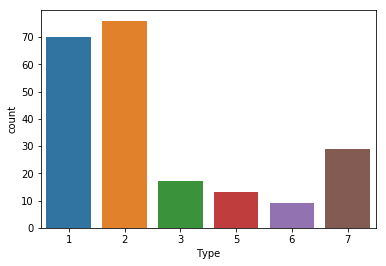

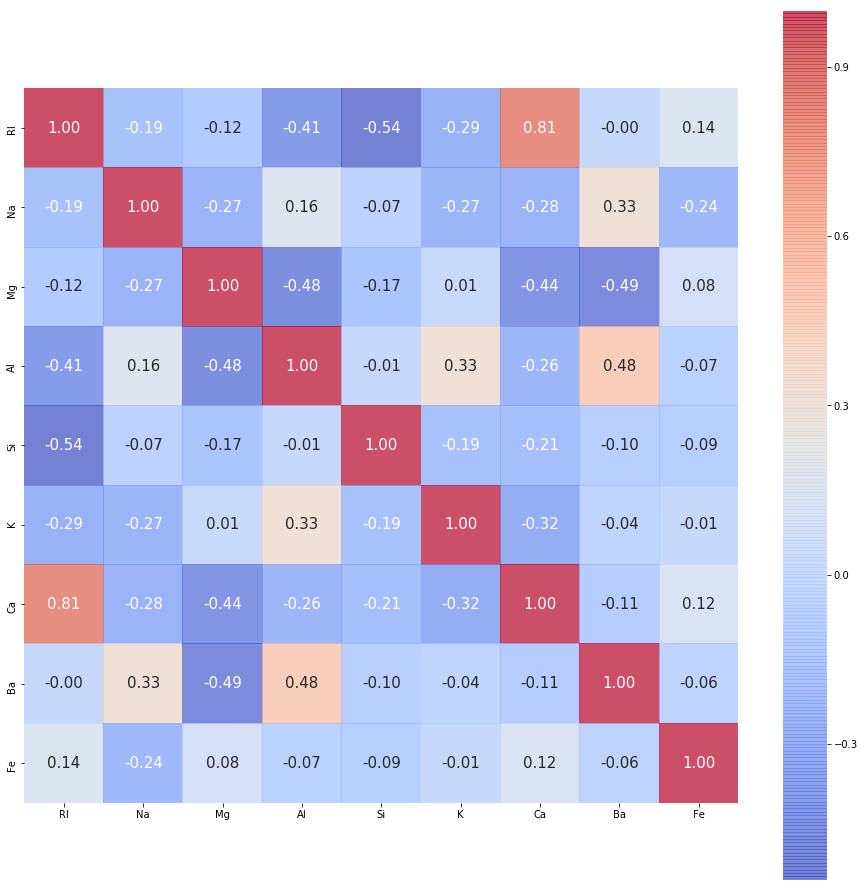

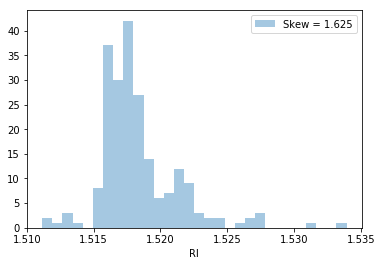

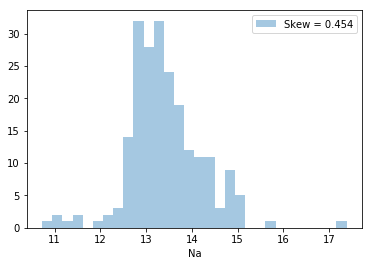

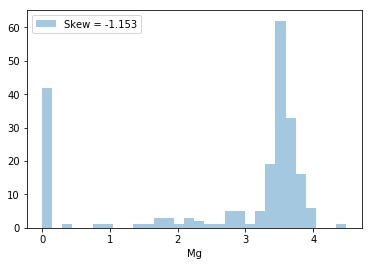

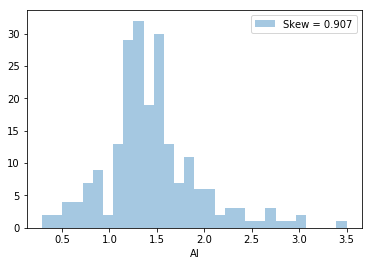

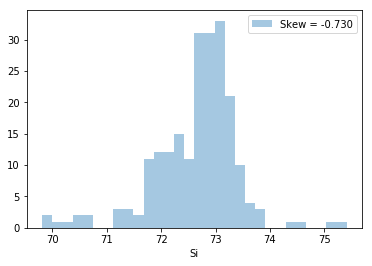

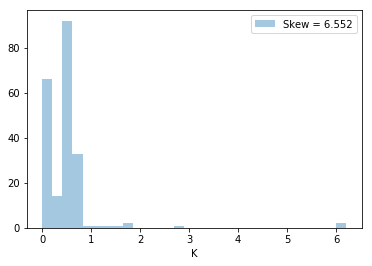

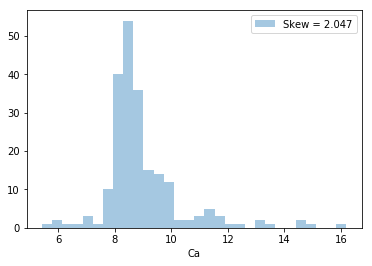

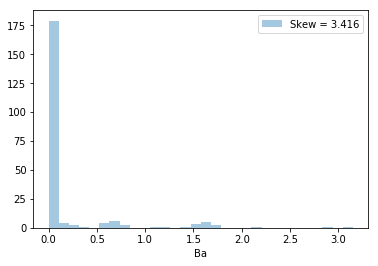

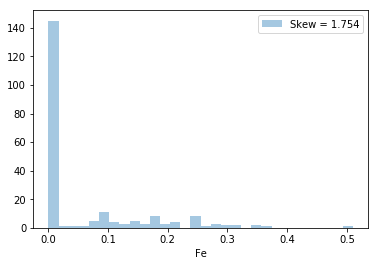

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data=pd.read_csv('glass.csv')
#data.head()

sns.countplot(data['Type'])
plt.show()
y=data['Type']
data.drop(labels={'Type'},axis=1,inplace=True)


columns=data.columns[:9]
corr=data[columns].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr,cbar=True,square=True,annot=True,fmt='.2f',annot_kws={'size':15},xticklabels=columns,yticklabels=columns,alpha=0.7,cmap='coolwarm')
plt.show()
for feat in data:
    skew = data[feat].skew()
    sns.distplot(data[feat], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()





In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.25)
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=100,random_state=100)
model.fit(data,y)
pd.Series(model.feature_importances_,index=data.columns).sort_values(ascending=False)

Al    0.165346
Mg    0.161355
RI    0.145839
Ca    0.123114
Na    0.108283
K     0.088207
Si    0.083858
Ba    0.080337
Fe    0.043661
dtype: float64

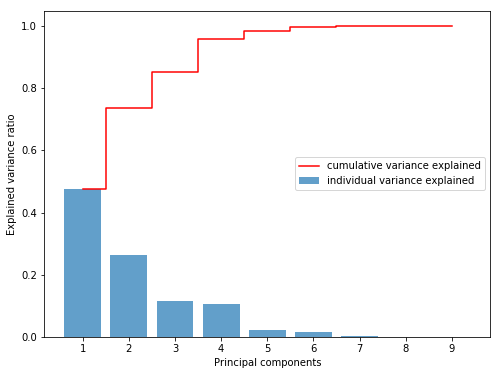

PC1 47.45509844313062
PC2 73.78478019920902
PC3 85.33847290382887
PC4 95.98614753121966
PC5 98.28548264401404
PC6 99.83174633645804
PC7 99.97655086985945
PC8 99.99998397272296
PC9 99.99999999999997
SVC 63.125 15.423703349066335
KNN 62.5 15.562374497485914
RF 76.875 5.625
ET 74.375 10.250762166785455
LR 55.625 13.820840242184987


In [65]:
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)

from sklearn.model_selection import (train_test_split, KFold , StratifiedKFold, 
                                     cross_val_score, GridSearchCV, 
                                     learning_curve, validation_curve)
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#from sklearn.pipelines import Pipeline
seed = 7

pca = PCA(random_state = seed)
pca.fit(X_train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.figure(figsize=(8,6))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained',color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()
# print(cum_var_exp)
# # Cumulative variance explained
for i, sum in enumerate(cum_var_exp):
    print("PC"+ str(i+1),cum_var_exp[i]*100)
#     print("PC" + (i), "Cumulative variance: %.3f% %" %(cum_var_exp[i]*100))

n_components = 5
pipelines = []
n_estimators = 200

#print(df.shape)
pipelines.append( ('SVC',
                   Pipeline([
                              ('sc', StandardScaler()),
 #                               ('pca', PCA(n_components = n_components, random_state=seed ) ),
                             ('SVC', SVC(random_state=seed))]) ) )
pipelines.append(('KNN',
                  Pipeline([ 
                              ('sc', StandardScaler()),
#                             ('pca', PCA(n_components = n_components, random_state=seed ) ),
                            ('KNN', KNeighborsClassifier()) ])))
pipelines.append( ('RF',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('RF', RandomForestClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))
pipelines.append( ('ET',
                   Pipeline([
                              ('sc', StandardScaler()),
#                              ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('ET', ExtraTreesClassifier(random_state=seed, n_estimators=n_estimators)) ]) ))


pipelines.append( ('LR',
                   Pipeline([
                              ('sc', StandardScaler()),
#                               ('pca', PCA(n_components = n_components, random_state=seed ) ), 
                             ('LR', LogisticRegression(random_state=seed)) ]) ))



results, names, times  = [], [] , []
num_folds = 10
scoring = 'accuracy'

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'accuracy',
                                n_jobs=-1) 
    results.append(cv_results)
    names.append(name)
    msg = print(name, 100*cv_results.mean(), 100*cv_results.std())


In [78]:
pipe_rfc = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('rfc', RandomForestClassifier(random_state=seed, n_jobs=-1) )])


#VERY IMPORTANT GRID SEARCH
# Set the grid parameters
param_grid_rfc =  [ {
    'rfc__n_estimators': [100, 200,300,400], # number of estimators
    'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
    'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
    'rfc__max_depth': [None, 5], # Max depth of the trees
    'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = KFold(n_splits=num_folds, random_state= seed)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring=scoring, verbose= 1, n_jobs=-1)

#Fit the pipeline
grid_rfc = grid_rfc.fit(X_train, y_train)



# Best score and best parameters
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.4min finished


-------Best score----------
77.5
-------Best params----------
{'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 100}


In [89]:
#from sklearn import metrics
rfc=RandomForestClassifier(criterion ='gini',random_state=seed, n_estimators=100,max_depth=None,min_samples_split=0.005,max_features=0.05)
rfc.fit(X_train,y_train)
Y_PRED=rfc.predict(X_test)
#grid_rfc.predict(X_train,y_train)
#lg1pre=grid_rfc.predict(X_test)
print('Accuracy for RFC is ',metrics.accuracy_score(Y_PRED,y_test))


Accuracy for RFC is  0.8333333333333334
